plan now is to take everything that looks like it could work and mix it all up into a (hopefully) uncorrolated soup

need to make the point againn this is historically only

i am also going to remake all features for the sake of error prevention ie. can check consistency against previous work

In [1]:
# importing packages and data

import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

df = pd.read_csv("extended_data.csv", 
dtype={0: float, 1: str, 2: float,  3: float,  4: float,  5: float,  6: float,  7: float,  8: int}
)

# fill missed funding periods with 0
df["funding"] = df["funding"].fillna(0)

# check number of assets
print(len(df["asset"].unique()))

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

57
Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate]
Index: []


In [2]:
# define constants
RETURNS_LOOKBACK = 30
TARGET_VOLATILITY = 1/math.sqrt(365)
print(TARGET_VOLATILITY)

0.052342392259021375


In [3]:
# making time readable
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

# getting returns and return and funding volatility

# asset retuns
df["returns"] = (
    df.groupby("asset")["close"]
      .transform(lambda x: x.pct_change())
)

# asset returns inclusive of funding
df["returns_funding"] = df["returns"] - df["funding"]

# next day asset returns inclusive of funding
df["next_returns_funding"] = (
    df.groupby("asset")["returns_funding"]
      .shift(-1)
)

# asset returns and funding volatility
df["rolling_returns_funding_vol"] = (
    df.groupby("asset")["returns_funding"]
      .rolling(window=RETURNS_LOOKBACK)
      .std()
      .reset_index(level=0, drop=True)
)

# check work
df.iloc[50:56].head()

,timestamp,asset,open,high,low,close,volume,funding,funding inaccurate,returns,returns_funding,next_returns_funding,rolling_returns_funding_vol
50,2025-01-25 20:00:00,1000BONK-USD,0.029637,0.029813,0.028716,0.029260,574900.0,-0.000037,24,-0.012721,-0.012684,-0.154063,0.075372
51,2025-01-26 20:00:00,1000BONK-USD,0.029260,0.029260,0.024299,0.024748,1239300.0,-0.000141,24,-0.154204,-0.154063,0.008947,0.080323
52,2025-01-27 20:00:00,1000BONK-USD,0.024748,0.026785,0.024748,0.024954,982400.0,-0.000623,24,0.008324,0.008947,-0.001621,0.079880
53,2025-01-28 20:00:00,1000BONK-USD,0.024954,0.025741,0.022771,0.024913,1317900.0,-0.000022,24,-0.001643,-0.001621,0.014194,0.079750
54,2025-01-29 20:00:00,1000BONK-USD,0.024913,0.026438,0.023934,0.025254,1091300.0,-0.000506,24,0.013688,0.014194,-0.012058,0.079690


important to make the point here that i am dropping the 40 and 55 sma signal but it is bad to become fussy when picking as it is a basis for overfitting. instead i think of it as my effect goes from useless to weak to strong to weak to useless as i vary some variable ie. time horizon it has data for, so cutting off the very edge of it is overfitting technically but also probably helpful - i just shouldnt become too picky

In [4]:
# creating funding signals

for i in [3, 5, 10, 15, 25, 40, 55]:
    
    df[f"funding_sig_1v{i}"] = (
    df.groupby("asset")["funding"]
      .rolling(window=i)
      .mean()
      .reset_index(level=0, drop=True)
    )

    df[f"funding_sig_2v{i}"] = df["funding"] - df[f"funding_sig_1v{i}"]

df = df.drop(columns = ["funding_sig_1v40", "funding_sig_1v55"])

In [5]:
# scaling returns and funding by volatility
df["returns_funding_volscaled"] = df["returns_funding"]*(TARGET_VOLATILITY/df["rolling_returns_funding_vol"])

# next day asset returns and funding scaled by volatility
df["next_returns_funding_volscaled"] = (
    df.groupby("asset")["returns_funding_volscaled"]
      .shift(-1)
)

# editing to remove what wont yet include a volatility scale and final day
df = df[df.groupby('asset').cumcount() > 55].copy()
df = df.groupby('asset').head(-1).copy()

#check if missing values remaining
nan_rows = df.isna().any(axis=1)
rows_with_nan = df[nan_rows]
print(rows_with_nan)

Empty DataFrame
Columns: [timestamp, asset, open, high, low, close, volume, funding, funding inaccurate, returns, returns_funding, next_returns_funding, rolling_returns_funding_vol, funding_sig_1v3, funding_sig_2v3, funding_sig_1v5, funding_sig_2v5, funding_sig_1v10, funding_sig_2v10, funding_sig_1v15, funding_sig_2v15, funding_sig_1v25, funding_sig_2v25, funding_sig_2v40, funding_sig_2v55, returns_funding_volscaled, next_returns_funding_volscaled]
Index: []

[0 rows x 27 columns]


In [6]:
idx_max = df["next_returns_funding_volscaled"].idxmax()
print(df.loc[idx_max])
idx_min = df["next_returns_funding_volscaled"].idxmin()
print(df.loc[idx_min])

timestamp                         2025-02-28 20:00:00
asset                                         ADA-USD
open                                            0.636
high                                           0.6517
low                                            0.6282
close                                          0.6424
volume                                         1560.0
funding                                     -0.000301
funding inaccurate                                 24
returns                                      0.010063
returns_funding                              0.010364
next_returns_funding                         0.620888
rolling_returns_funding_vol                  0.042673
funding_sig_1v3                              0.000526
funding_sig_2v3                             -0.000827
funding_sig_1v5                              0.000498
funding_sig_2v5                             -0.000799
funding_sig_1v10                            -0.000479
funding_sig_2v10            

going to check information co-efficient between signals now, if one signal can predict another signal well... no point in using both of them

In [7]:
signal_cols = ["funding_sig_1v3", "funding_sig_1v5", "funding_sig_1v10", "funding_sig_1v15", 
               "funding_sig_1v25", "funding_sig_2v3", "funding_sig_2v5", "funding_sig_2v10", 
               "funding_sig_2v15", "funding_sig_2v25", "funding_sig_2v40", "funding_sig_2v55"]

rows = []

for time in df["timestamp"].unique():
    tempdf = df[df["timestamp"] == time][signal_cols]
    corr = tempdf.corr(method="spearman")
    
    # upper triangle indices (unique pairs only)
    iu = np.triu_indices_from(corr, k=1)
    
    for i, j in zip(*iu):
        rows.append({
            "timestamp": time,
            "sig_x": corr.index[i],
            "sig_y": corr.columns[j],
            "correlation": corr.iat[i, j]
        })

summary = pd.DataFrame(rows)
print(summary.head(5))


            timestamp            sig_x             sig_y  correlation
0 2025-01-31 20:00:00  funding_sig_1v3   funding_sig_1v5     0.940769
1 2025-01-31 20:00:00  funding_sig_1v3  funding_sig_1v10     0.757692
2 2025-01-31 20:00:00  funding_sig_1v3  funding_sig_1v15     0.470769
3 2025-01-31 20:00:00  funding_sig_1v3  funding_sig_1v25     0.500769
4 2025-01-31 20:00:00  funding_sig_1v3   funding_sig_2v3    -0.185385


In [8]:
summary_avg = summary.groupby(["sig_x", "sig_y"])["correlation"].mean().reset_index()
print(summary_avg.head(50))

               sig_x             sig_y  correlation
0   funding_sig_1v10  funding_sig_1v15     0.913949
1   funding_sig_1v10  funding_sig_1v25     0.791753
2   funding_sig_1v10  funding_sig_2v10    -0.207706
3   funding_sig_1v10  funding_sig_2v15    -0.133971
4   funding_sig_1v10  funding_sig_2v25    -0.028962
5   funding_sig_1v10   funding_sig_2v3    -0.084531
6   funding_sig_1v10  funding_sig_2v40     0.050719
7   funding_sig_1v10   funding_sig_2v5    -0.134145
8   funding_sig_1v10  funding_sig_2v55     0.087375
9   funding_sig_1v15  funding_sig_1v25     0.878211
10  funding_sig_1v15  funding_sig_2v10    -0.201796
11  funding_sig_1v15  funding_sig_2v15    -0.237028
12  funding_sig_1v15  funding_sig_2v25    -0.137750
13  funding_sig_1v15   funding_sig_2v3    -0.073743
14  funding_sig_1v15  funding_sig_2v40    -0.043943
15  funding_sig_1v15   funding_sig_2v5    -0.118021
16  funding_sig_1v15  funding_sig_2v55    -0.000449
17  funding_sig_1v25  funding_sig_2v10    -0.173615
18  funding_

going to drop all signals that have an ic of > abs(0.9) to another signal

fyi no special reason for 0.9, will revert back to this later i just need to pick something for now

In [9]:
corr_signals = []

for index in summary_avg.index:
    if abs(summary_avg["correlation"].iloc[index]) > 0.9:

        corr_signals.append(summary_avg["sig_y"].iloc[index])

print(corr_signals)

['funding_sig_1v15', 'funding_sig_2v40', 'funding_sig_2v55']


going to equal weight all the signals into a mean one to use for each day and check how it does

In [10]:
signal_cols = ["funding_sig_1v3", "funding_sig_1v5", "funding_sig_1v10", "funding_sig_1v25", 
               "funding_sig_2v3", "funding_sig_2v5", "funding_sig_2v10", 
               "funding_sig_2v15", "funding_sig_2v25"]

df["avg_signal"] = df[signal_cols].mean(axis=1)

print(df[["asset", "avg_signal"]].head(10))


           asset  avg_signal
56  1000BONK-USD   -0.000136
57  1000BONK-USD   -0.000145
58  1000BONK-USD   -0.001375
59  1000BONK-USD   -0.001676
60  1000BONK-USD   -0.000766
61  1000BONK-USD   -0.000800
62  1000BONK-USD   -0.000669
63  1000BONK-USD   -0.000416
64  1000BONK-USD   -0.000903
65  1000BONK-USD   -0.000606


In [11]:
# create avg signal deciles
df["avgsignal_decile"] = 0

# per day deciles across all assets
df['avgsignal_decile'] = df.groupby('timestamp')['avg_signal'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
56    2025-01-31 20:00:00  1000BONK-USD       0.024936       0.025613   
472   2025-01-31 20:00:00  1000PEPE-USD       0.014007       0.014258   
762   2025-01-31 20:00:00  1000SHIB-USD       0.018872       0.019227   
1411  2025-01-31 20:00:00       ADA-USD       0.945700       0.954300   
1852  2025-01-31 20:00:00       ARB-USD       0.649000       0.651800   
2271  2025-01-31 20:00:00      AVAX-USD      34.720000      35.070000   
2909  2025-01-31 20:00:00       BNB-USD     679.200000     681.400000   
3332  2025-01-31 20:00:00       BTC-USD  102375.600000  102753.100000   
3780  2025-01-31 20:00:00      DOGE-USD       0.327960       0.330150   
4475  2025-01-31 20:00:00       ETH-USD    3339.420000    3341.010000   
5021  2025-01-31 20:00:00      GOAT-USD       0.203700       0.207700   
6751  2025-01-31 20:00:00      LINK-USD      24.897000      25.905000   
7157  2025-01-31 20:00:00       LTC-USD     126.150

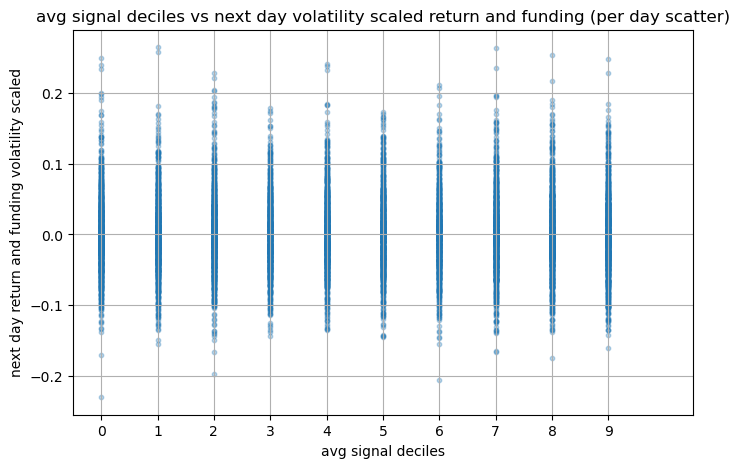

In [12]:
# scatter plot to gain initial intuiton
plt.figure(figsize=(8,5))
plt.scatter(
    df["avgsignal_decile"], 
    df["next_returns_funding_volscaled"], 
    alpha=0.3, 
    s=10
)

plt.xlabel("avg signal deciles")
plt.ylabel("next day return and funding volatility scaled")
plt.title("avg signal deciles vs next day volatility scaled return and funding (per day scatter)")
plt.grid(True)

plt.xlim(-0.5, 10.5)
plt.xticks(range(0, 10))
plt.show()

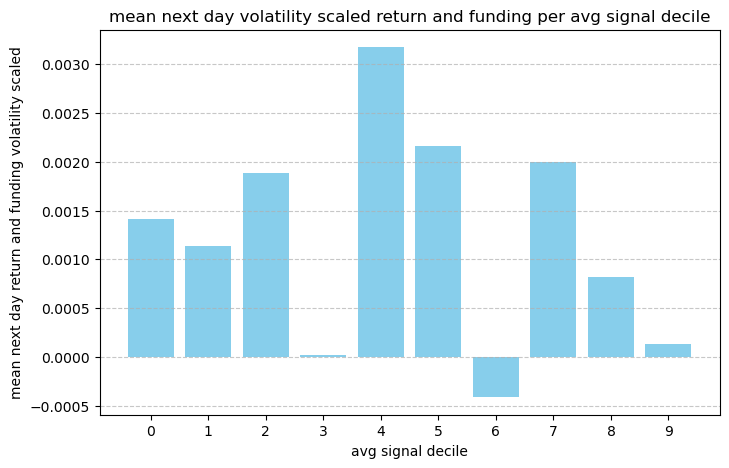

In [13]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("avgsignal_decile")["next_returns_funding_volscaled"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("avg signal decile")
plt.ylabel("mean next day return and funding volatility scaled")
plt.title("mean next day volatility scaled return and funding per avg signal decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

okay this isnt great, i suspect its because dropping highly corrolated signals and equal weighing the rest sounds good but in reality your just getting rid of good signals and then giving more weight than you should to bad ones ie. more chance your uncorrolated signal is uncorrolated because its just bad than because you struck gold

going to flip this on its head now and keep only highly corrolated ones and see if (historic) results are better

In [14]:
corr_signals = []

for index in summary_avg.index:
    if abs(summary_avg["correlation"].iloc[index]) > 0.9:

        corr_signals.append(summary_avg["sig_y"].iloc[index])
        corr_signals.append(summary_avg["sig_x"].iloc[index])

print(corr_signals)

['funding_sig_1v15', 'funding_sig_1v10', 'funding_sig_2v40', 'funding_sig_2v25', 'funding_sig_2v55', 'funding_sig_2v40']


In [15]:
df["avg_signal"] = 0

df["avg_signal"] = df[corr_signals].mean(axis=1)

print(df)

                timestamp         asset      open      high       low  \
56    2025-01-31 20:00:00  1000BONK-USD  0.024936  0.025613  0.022493   
57    2025-02-01 20:00:00  1000BONK-USD  0.022576  0.022576  0.018947   
58    2025-02-02 20:00:00  1000BONK-USD  0.019681  0.020000  0.016273   
59    2025-02-03 20:00:00  1000BONK-USD  0.019926  0.020700  0.017648   
60    2025-02-04 20:00:00  1000BONK-USD  0.018604  0.018849  0.017531   
...                   ...           ...       ...       ...       ...   
13984 2025-09-16 20:00:00       XRP-USD  3.046800  3.068200  2.983300   
13985 2025-09-17 20:00:00       XRP-USD  3.036900  3.137600  3.013000   
13986 2025-09-18 20:00:00       XRP-USD  3.111600  3.111600  2.985600   
13987 2025-09-19 20:00:00       XRP-USD  2.987800  3.008900  2.966800   
13988 2025-09-20 20:00:00       XRP-USD  2.979400  3.011000  2.954900   

          close     volume   funding  funding inaccurate   returns  ...  \
56     0.022576   696700.0 -0.000222            

In [16]:
# create funding deciles
df["avgsignal_decile"] = 0

# per day deciles across all assets
df['avgsignal_decile'] = df.groupby('timestamp')['avg_signal'] \
    .transform(lambda x: pd.qcut(x.rank(method='first'), 10, labels=False))

# check df
unique_times = df["timestamp"].unique()
#print(unique_times)
print(df[df["timestamp"] == unique_times[0]])

                timestamp         asset           open           high  \
56    2025-01-31 20:00:00  1000BONK-USD       0.024936       0.025613   
472   2025-01-31 20:00:00  1000PEPE-USD       0.014007       0.014258   
762   2025-01-31 20:00:00  1000SHIB-USD       0.018872       0.019227   
1411  2025-01-31 20:00:00       ADA-USD       0.945700       0.954300   
1852  2025-01-31 20:00:00       ARB-USD       0.649000       0.651800   
2271  2025-01-31 20:00:00      AVAX-USD      34.720000      35.070000   
2909  2025-01-31 20:00:00       BNB-USD     679.200000     681.400000   
3332  2025-01-31 20:00:00       BTC-USD  102375.600000  102753.100000   
3780  2025-01-31 20:00:00      DOGE-USD       0.327960       0.330150   
4475  2025-01-31 20:00:00       ETH-USD    3339.420000    3341.010000   
5021  2025-01-31 20:00:00      GOAT-USD       0.203700       0.207700   
6751  2025-01-31 20:00:00      LINK-USD      24.897000      25.905000   
7157  2025-01-31 20:00:00       LTC-USD     126.150

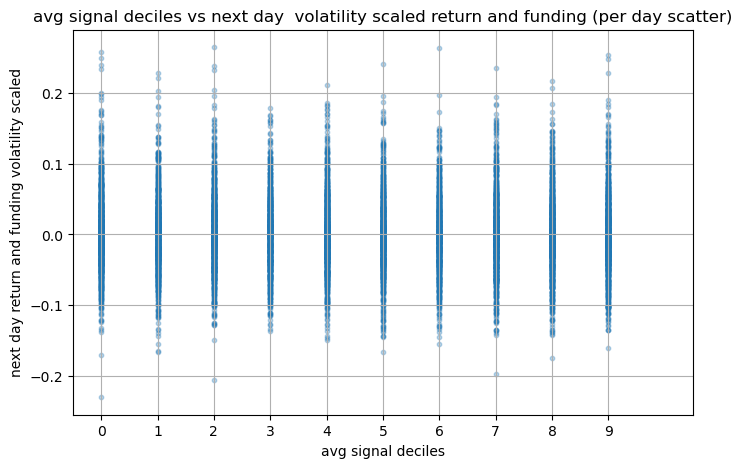

In [17]:
# scatter plot to gain initial intuiton
plt.figure(figsize=(8,5))
plt.scatter(
    df["avgsignal_decile"], 
    df["next_returns_funding_volscaled"], 
    alpha=0.3, 
    s=10
)

plt.xlabel("avg signal deciles")
plt.ylabel("next day return and funding volatility scaled")
plt.title("avg signal deciles vs next day  volatility scaled return and funding (per day scatter)")
plt.grid(True)

plt.xlim(-0.5, 10.5)
plt.xticks(range(0, 10))
plt.show()

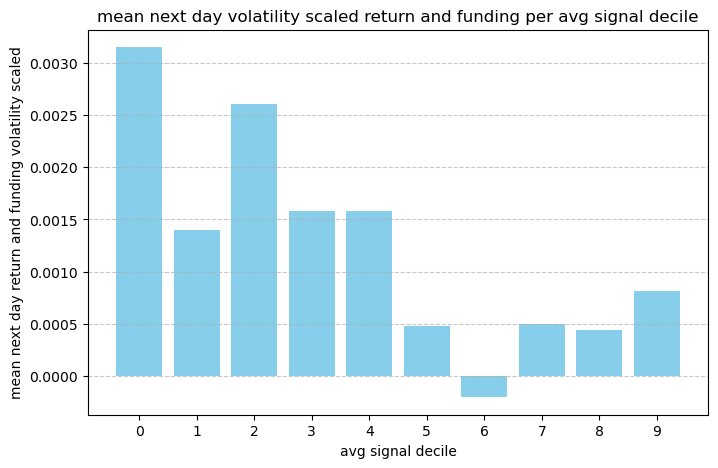

In [18]:
# decile plot to aim to see effects more clearly
decile_means = df.groupby("avgsignal_decile")["next_returns_funding_volscaled"].mean()

plt.figure(figsize=(8,5))
plt.bar(decile_means.index, decile_means.values, color="skyblue")
plt.xlabel("avg signal decile")
plt.ylabel("mean next day return and funding volatility scaled")
plt.title("mean next day volatility scaled return and funding per avg signal decile")
plt.xticks(decile_means.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

this is much better; the signals are highly corrolated which isnt great but in aggregate they have histroically worked better - we can work from here

going to break the scatterplot and decile plot out by periods and check more closely now

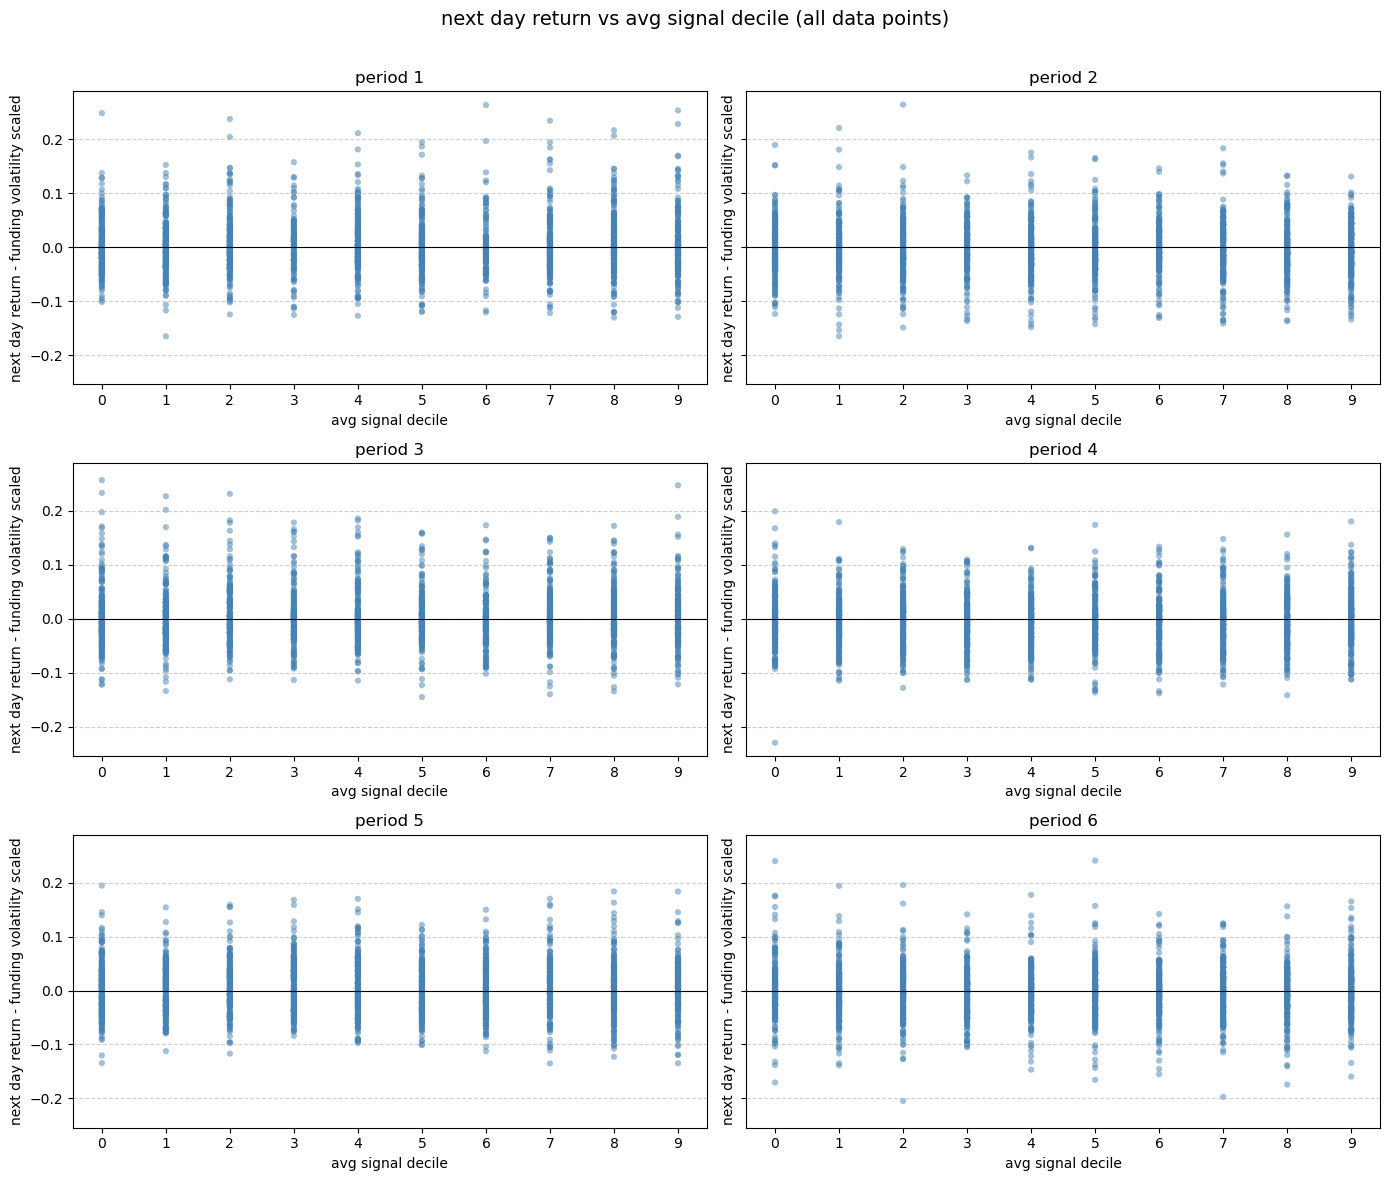

In [19]:
# create subplots (3 rows × 2 columns)
df["period"] = pd.qcut(df["timestamp"].rank(method="first"), 6, labels=False) + 1

fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    
    # scatter all data points
    ax.scatter(subset["avgsignal_decile"], subset["next_returns_funding_volscaled"], 
               color="steelblue", alpha=0.5, s=20, edgecolor="none")
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("avg signal decile")
    ax.set_ylabel("next day return - funding volatility scaled")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xticks(sorted(df["avgsignal_decile"].unique()))

plt.suptitle("next day return vs avg signal decile (all data points)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

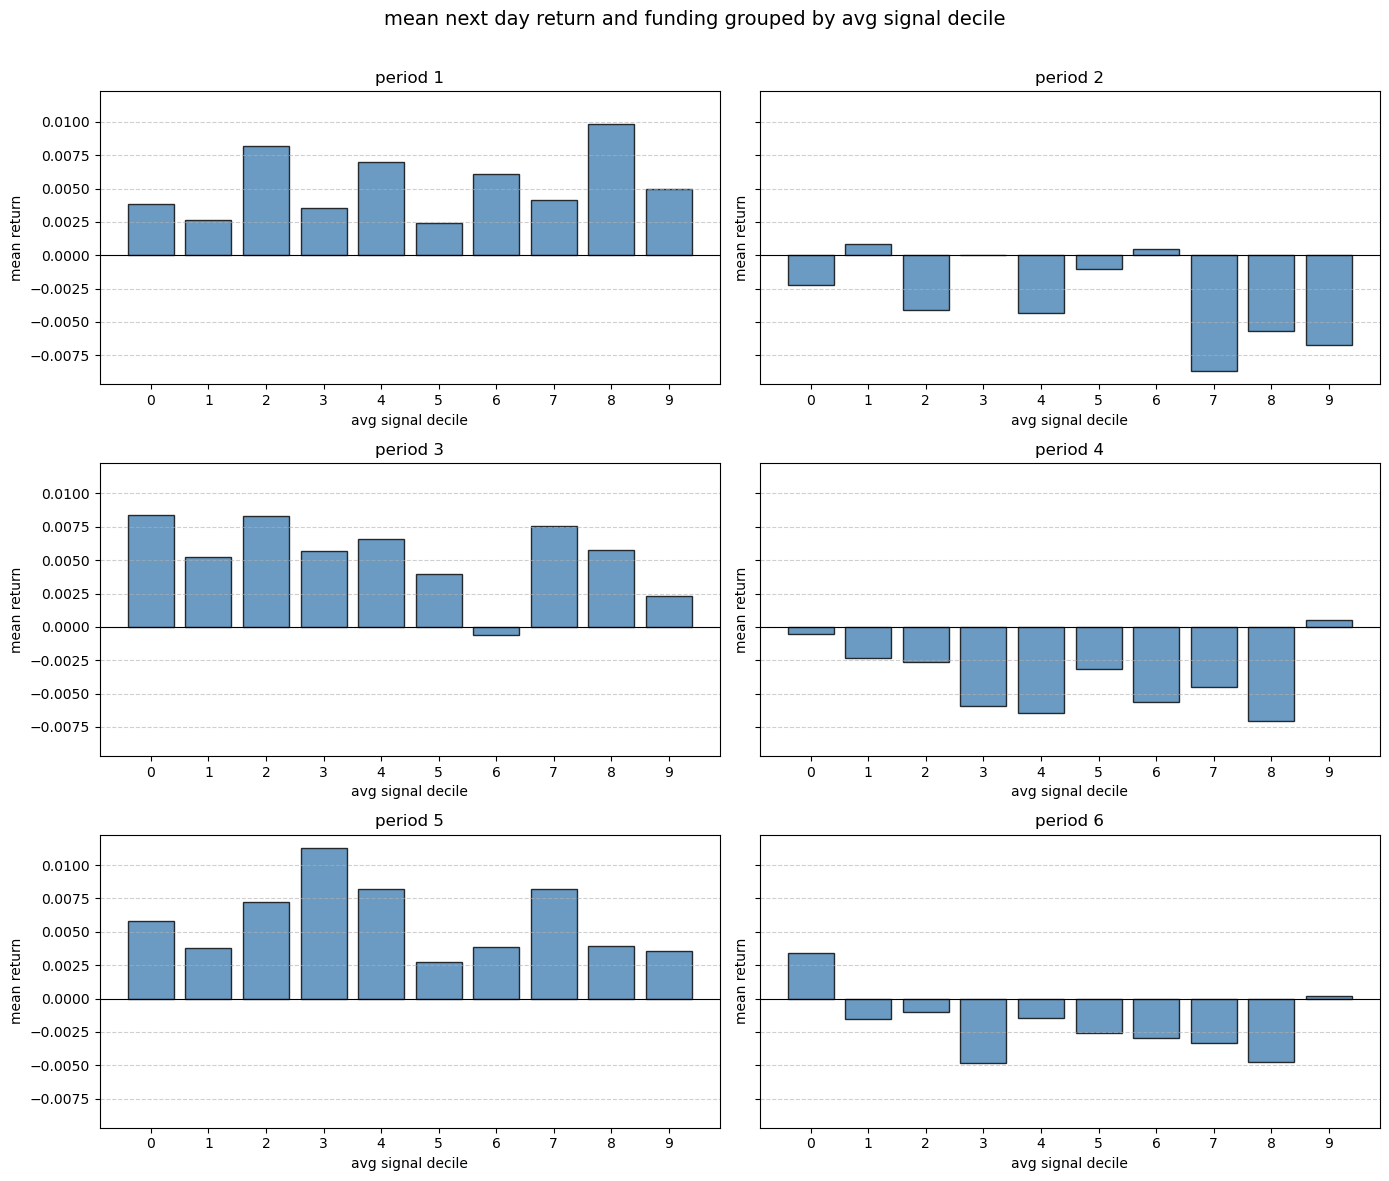

In [20]:
# create subplots (3 rows × 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes, start=1):
    subset = df[df["period"] == i]
    decile_means = subset.groupby("avgsignal_decile")["next_returns_funding_volscaled"].mean()
    
    bars = ax.bar(decile_means.index, decile_means.values, 
                  color="steelblue", edgecolor="black", alpha=0.8)
    
    # formatting
    ax.set_title(f"period {i}", fontsize=12)
    ax.set_xlabel("avg signal decile")
    ax.set_ylabel("mean return")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.set_xticks(decile_means.index)

plt.suptitle("mean next day return and funding grouped by avg signal decile", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

this seems more stable; final thing before moving on to checking further details is to cut off the top and bottom 2% and check how dependant returns are on outliers

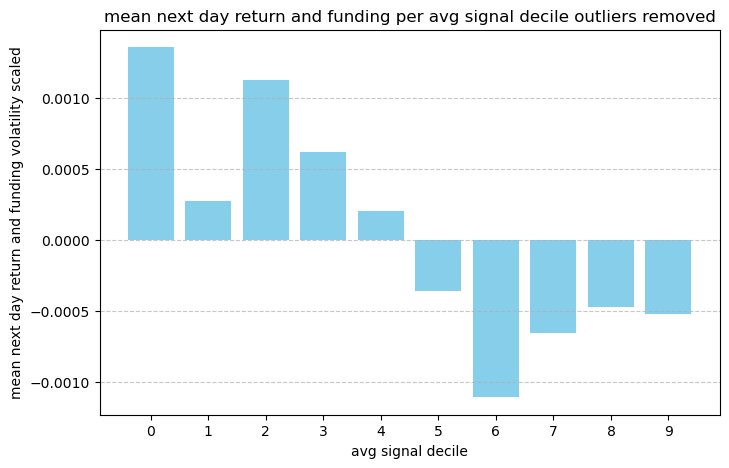

In [21]:
decile_means_v2 = (
    df.groupby("avgsignal_decile")["next_returns_funding_volscaled"]
      .apply(lambda g: g[
          (g >= g.quantile(0.05)) &
          (g <= g.quantile(0.95))
      ].mean())
)

plt.figure(figsize=(8,5))
plt.bar(decile_means_v2.index, decile_means_v2.values, color="skyblue")
plt.xlabel("avg signal decile")
plt.ylabel("mean next day return and funding volatility scaled")
plt.title("mean next day return and funding per avg signal decile outliers removed")
plt.xticks(decile_means_v2.index)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

okay all good - different results but not in a manner that is against the direction youd be trading, the signals have stability in returns

also a side note - handle the outliers better and you can probably get results closer to most recent graph here which would be better to have (making money in crypto going short seems harder and therefore has an important place in portifolios)